In [1]:
import pcDataLoader as pc
import pandas as pd
import os
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt

In [2]:
home = os.path.expanduser('~')

In [3]:
path = home + "/Documents/PhD/github/private_repo/PhysiBoSS/output"
path

'/home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output'

In [4]:
file = "/output00000000.xml"
path_file = path + file
mcds = pc.pyMCDS(path_file)
mcds.data["metadata"]["current_time"]

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000000.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000000_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000000_cells.mat


0.0

In [5]:
phase_dict = {}

phase_dict[4] = "G0G1_phase"
phase_dict[10] = "S_phase"
phase_dict[11] = "G2M_phase"
phase_dict[100] = "apoptotic"



In [6]:
mcds.get_cell_df()

,ID,position_x,position_y,position_z,total_volume,cell_type,cycle_model,current_phase,elapsed_time_in_phase,nuclear_volume,...,internalized_total_substrates,fraction_released_at_death,fraction_transferred_when_ingested,dead_phagocytosis_rate,live_phagocytosis_rates,attack_rates,damage_rate,fusion_rates,transformation_rates,somedata
0,0.0,0.000000,0.00000,0.0,2494.0,0.0,2.0,4.0,0.0,540.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,15.984150,0.00000,0.0,2494.0,0.0,2.0,4.0,0.0,540.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,2.0,-15.984150,0.00000,0.0,2494.0,0.0,2.0,4.0,0.0,540.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,3.0,7.992075,13.84268,0.0,2494.0,0.0,2.0,4.0,0.0,540.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,4.0,7.992075,-13.84268,0.0,2494.0,0.0,2.0,4.0,0.0,540.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5,5.0,-7.992075,13.84268,0.0,2494.0,0.0,2.0,4.0,0.0,540.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
6,6.0,-7.992075,-13.84268,0.0,2494.0,0.0,2.0,4.0,0.0,540.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7,7.0,23.976225,13.84268,0.0,2494.0,0.0,2.0,4.0,0.0,540.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8,8.0,23.976225,-13.84268,0.0,2494.0,0.0,2.0,4.0,0.0,540.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
9,9.0,-23.976225,13.84268,0.0,2494.0,0.0,2.0,4.0,0.0,540.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [7]:
xml_files = []


for folder, cose, files in os.walk(path):
    for name in files:
        if name.endswith(".xml") & name.startswith("output"):
            xml_files.append(name)
            
xml_files.sort()
xml_files

['output00000000.xml',
 'output00000001.xml',
 'output00000002.xml',
 'output00000003.xml',
 'output00000004.xml',
 'output00000005.xml',
 'output00000006.xml',
 'output00000007.xml',
 'output00000008.xml',
 'output00000009.xml',
 'output00000010.xml',
 'output00000011.xml',
 'output00000012.xml',
 'output00000013.xml',
 'output00000014.xml',
 'output00000015.xml',
 'output00000016.xml',
 'output00000017.xml',
 'output00000018.xml',
 'output00000019.xml',
 'output00000020.xml',
 'output00000021.xml',
 'output00000022.xml',
 'output00000023.xml',
 'output00000024.xml',
 'output00000025.xml',
 'output00000026.xml',
 'output00000027.xml',
 'output00000028.xml',
 'output00000029.xml',
 'output00000030.xml',
 'output00000031.xml',
 'output00000032.xml',
 'output00000033.xml',
 'output00000034.xml',
 'output00000035.xml',
 'output00000036.xml',
 'output00000037.xml',
 'output00000038.xml',
 'output00000039.xml',
 'output00000040.xml',
 'output00000041.xml',
 'output00000042.xml',
 'output000

In [8]:
full_data = pd.DataFrame(columns=["time_step", "ID", "phase", "duration"])    

for file in xml_files:
    
    mcds = pc.pyMCDS(file, path)
    
    time = mcds.data["metadata"]["current_time"]
    
    for i in mcds.data["discrete_cells"]["ID"]:
        ID = i
        index = np.where(mcds.data["discrete_cells"]["ID"] == ID)
        phase = phase_dict[int(mcds.data["discrete_cells"]["current_phase"][index])]
        phase_duration = int(mcds.data["discrete_cells"]["elapsed_time_in_phase"][index][0])
        new_entry = pd.Series({"time_step":time, "ID":ID,
                     "phase":phase, "duration":phase_duration})
        full_data = pd.concat([full_data, new_entry.to_frame().T], ignore_index=True)



Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000000.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000000_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000000_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000001.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000001_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000001_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000002.xml
Reading /home/marco/Documents/PhD/gi

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000019_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000020.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000020_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000020_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000021.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000021_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000021_cells.

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000040_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000041.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000041_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000041_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000042.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000042_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000042_cells.

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000062_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000063.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000063_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000063_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000064.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000064_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000064_cells.

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000081_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000082.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000082_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000082_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000083.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000083_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000083_cells.

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000101_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000102.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000102_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000102_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000103.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000103_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000103_cells.

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000124_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000124_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000125.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000125_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000125_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000126.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/git

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000144_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000144_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000145.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000145_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000145_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000146.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/git

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000164.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000164_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000164_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000165.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000165_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000165_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000166.xml
Reading /home/marco/Documents/PhD/gi

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000183_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000184.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000184_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000184_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000185.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000185_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000185_cells.

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000203.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000203_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000203_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000204.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000204_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000204_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000205.xml
Reading /home/marco/Documents/PhD/gi

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000224_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000225.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000225_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000225_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000226.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000226_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000226_cells.

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000244_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000245.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000245_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000245_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000246.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000246_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000246_cells.

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000265_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000265_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000266.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000266_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000266_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000267.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/git

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000284_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000285.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000285_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000285_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000286.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000286_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000286_cells.

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000305.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000305_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000305_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000306.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000306_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000306_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000307.xml
Reading /home/marco/Documents/PhD/gi

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000324_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000325.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000325_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000325_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000326.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000326_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000326_cells.

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000345.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000345_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000345_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000346.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000346_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000346_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000347.xml
Reading /home/marco/Documents/PhD/gi

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000364_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000365.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000365_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000365_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000366.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000366_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000366_cells.

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000386.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000386_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000386_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000387.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000387_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000387_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000388.xml
Reading /home/marco/Documents/PhD/gi

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000405.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000405_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000405_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000406.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000406_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000406_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000407.xml
Reading /home/marco/Documents/PhD/gi

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000426_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000426_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000427.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000427_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000427_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000428.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/git

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000445_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000446.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000446_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000446_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000447.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000447_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000447_cells.

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000465.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000465_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000465_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000466.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000466_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000466_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output/output00000467.xml
Reading /home/marco/Documents/PhD/gi

In [9]:
def filter_duration(full_data, phase, ID):
    df = full_data[(full_data.phase == phase) & (full_data.ID == ID)]
    df2 = df.copy()

    for i in range(1, len(df["duration"])):
        index_prev = df["duration"].index[i - 1]
        index = df["duration"].index[i]
        if df["duration"][index] > df["duration"][index_prev]:
            df2.drop([index_prev], inplace=True)
    return df2

In [10]:
IDs = full_data.ID.drop_duplicates()
phases = ["G0G1_phase", "S_phase", "G2M_phase"]

filtered_data = pd.DataFrame(columns=["time_step", "ID", "phase", "duration"])

for name in IDs:
    for phase in phases:
        a = filter_duration(full_data, phase, name)
        filtered_data = pd.concat([filtered_data, a], ignore_index=True)

AVERAGE DURATION OF EACH CELL CYCLE PHASE


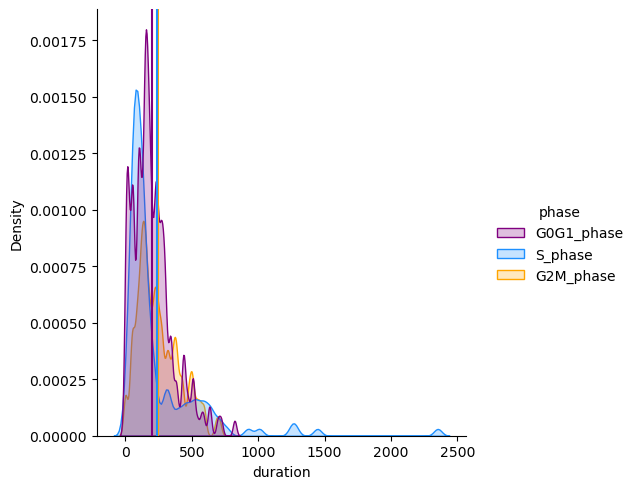

In [11]:
palette = ['purple', 'dodgerblue', 'orange']
print("AVERAGE DURATION OF EACH CELL CYCLE PHASE")
sb.displot(filtered_data, x="duration", kind="kde", hue='phase', fill=True, bw_adjust=.25, palette=palette)
plt.axvline(x=filtered_data[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
            color='orange')
plt.axvline(x=filtered_data[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
            color='purple')
plt.axvline(x=filtered_data[(filtered_data.phase == "S_phase")]["duration"].mean(),
            color='dodgerblue')

#change color into red blue yellow

In [12]:
filtered_data_duration = filtered_data[filtered_data['duration'].abs() < 1000]

AVERAGE DURATION OF EACH CELL CYCLE PHASE


/tmp/ipykernel_154260/543291753.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
/tmp/ipykernel_154260/543291753.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
/tmp/ipykernel_154260/543291753.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(x=filtered_data_duration[(filtered_data.phase == "S_phase")]["duration"].mean(),


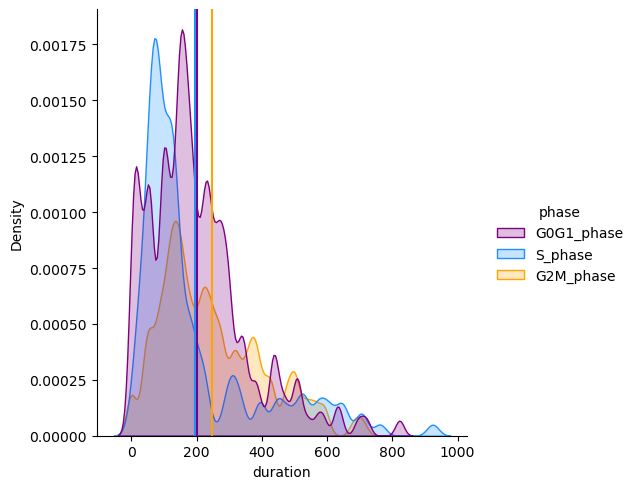

In [13]:
palette = ['purple', 'dodgerblue', 'orange']
print("AVERAGE DURATION OF EACH CELL CYCLE PHASE")
sb.displot(filtered_data_duration, x="duration", kind="kde", hue='phase', fill=True, bw_adjust=.25, palette=palette)
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
            color='orange')
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
            color='purple')
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "S_phase")]["duration"].mean(),
            color='dodgerblue')

#change color into red blue yellow

EVOLUTION OF THE CELL CYCLE DURING THE SIMULATION


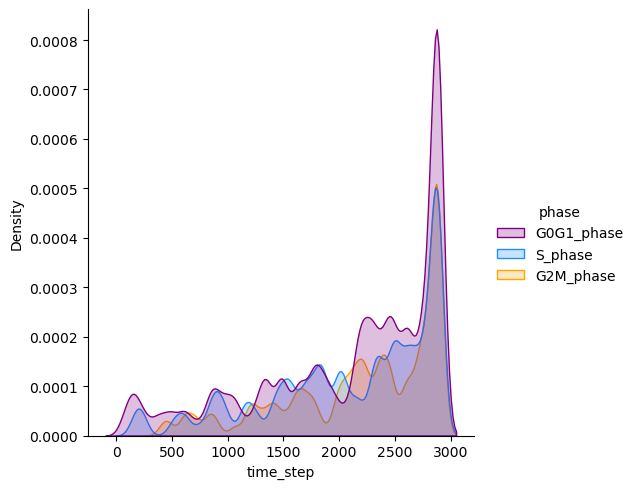

In [14]:
print("EVOLUTION OF THE CELL CYCLE DURING THE SIMULATION")
sb.displot(filtered_data, x="time_step", kind="kde", hue='phase', fill=True, bw_adjust=.20, palette=palette)

Average duration G0G1 phase:  200.98461538461538  minutes
Average duration S phase:  241.32857142857142  minutes
Average duration G2M phase:  246.20689655172413  minutes


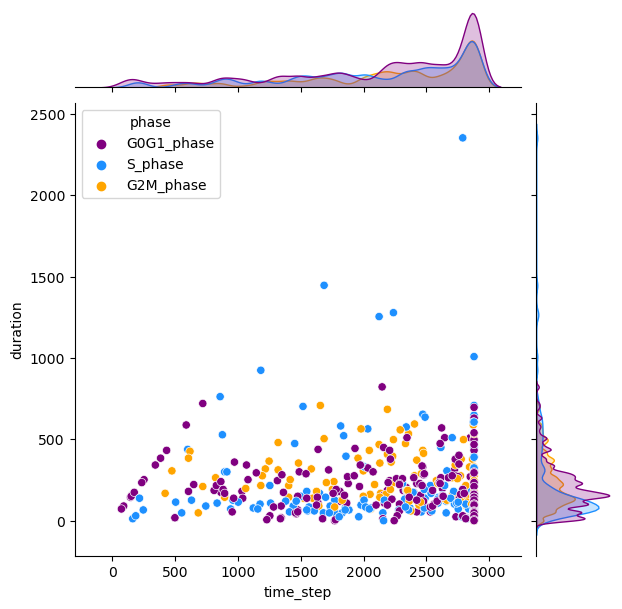

In [15]:
g = sb.JointGrid()
y, x, hue = filtered_data["duration"], filtered_data["time_step"], filtered_data["phase"]
sb.scatterplot(x=x, y=y, hue=hue,  ax=g.ax_joint, palette=palette)
sb.kdeplot(x=x, hue=hue, fill=True, bw_adjust=.25, ax=g.ax_marg_x, legend=False, palette=palette)
sb.kdeplot(y=y, hue=hue, fill=True, bw_adjust=.25, ax=g.ax_marg_y, legend=False, palette=palette)

print("Average duration G0G1 phase: ", filtered_data[(filtered_data.phase == "G0G1_phase")]["duration"].mean(), " minutes")
print("Average duration S phase: ", filtered_data[(filtered_data.phase == "S_phase")]["duration"].mean(), " minutes")
print("Average duration G2M phase: ", filtered_data[(filtered_data.phase == "G2M_phase")]["duration"].mean(), " minutes")

Average duration G0G1 phase:  200.98461538461538  minutes
Average duration S phase:  241.32857142857142  minutes
Average duration G2M phase:  246.20689655172413  minutes


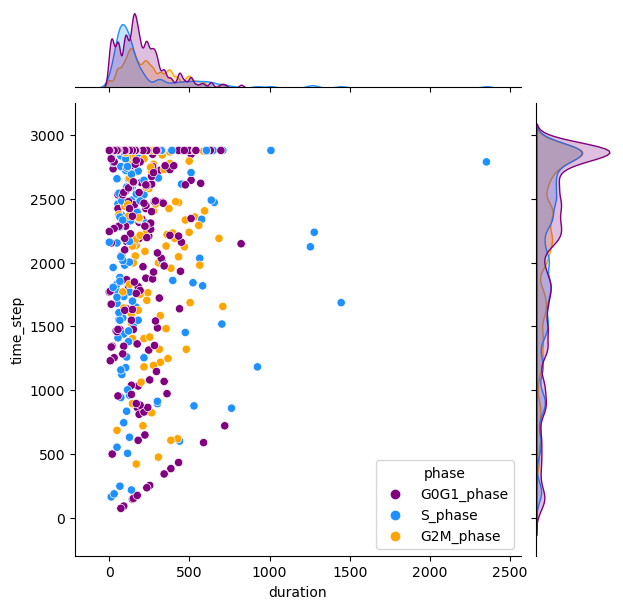

In [16]:
g = sb.JointGrid()
x, y, hue = filtered_data["duration"], filtered_data["time_step"], filtered_data["phase"]
sb.scatterplot(x=x, y=y, hue=hue,  ax=g.ax_joint, palette=palette)
sb.kdeplot(x=x, hue=hue, fill=True, bw_adjust=.25, ax=g.ax_marg_x, legend=False, palette=palette)
sb.kdeplot(y=y, hue=hue, fill=True, bw_adjust=.25, ax=g.ax_marg_y, legend=False, palette=palette)

print("Average duration G0G1 phase: ", filtered_data[(filtered_data.phase == "G0G1_phase")]["duration"].mean(), " minutes")
print("Average duration S phase: ", filtered_data[(filtered_data.phase == "S_phase")]["duration"].mean(), " minutes")
print("Average duration G2M phase: ", filtered_data[(filtered_data.phase == "G2M_phase")]["duration"].mean(), " minutes")

Average duration for each cell cycle phase, detail


<AxesSubplot:xlabel='phase', ylabel='duration'>

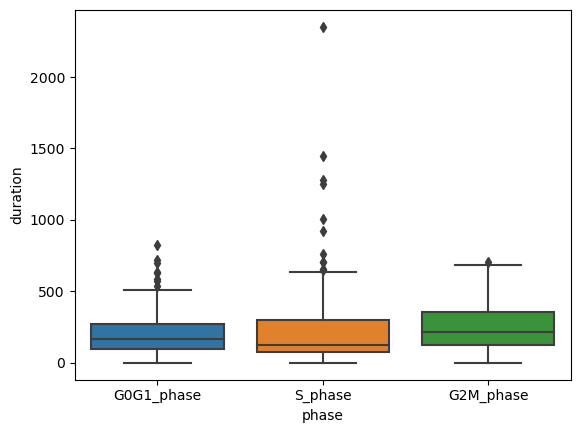

In [19]:
print("Average duration for each cell cycle phase, detail")
sb.boxplot(data=filtered_data, x='phase', y="duration")

<AxesSubplot:xlabel='time_step', ylabel='phase'>

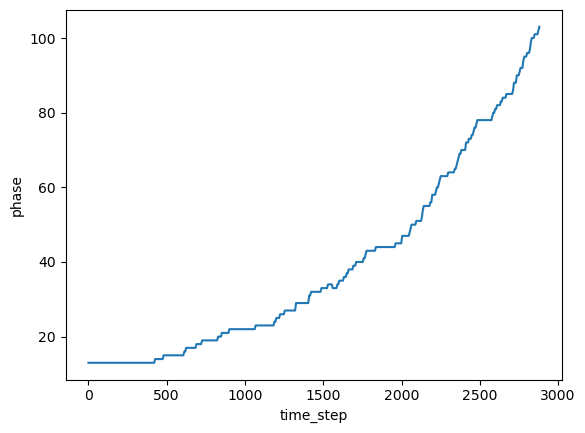

In [21]:
df1 = full_data.groupby('time_step').agg({'phase':'count'})

sb.lineplot(data=df1, x="time_step", y="phase")

<AxesSubplot:xlabel='time_step', ylabel='counts'>

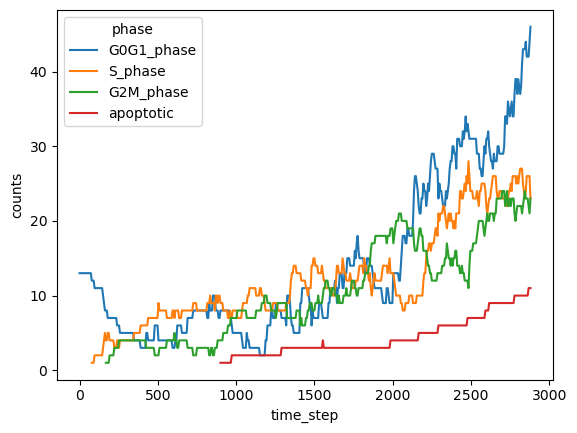

In [23]:
df2 = full_data.groupby(['time_step','phase'])['phase'].count().reset_index(name='counts')

sb.lineplot(data=df2, x="time_step", y="counts", hue="phase")

# PLK1 KNOCK-OUT ANALYSIS

In [25]:
path = home + "/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout"

xml_files = []


for folder, cose, files in os.walk(path):
    for name in files:
        if name.endswith(".xml") & name.startswith("output"):
            xml_files.append(name)
            
xml_files.sort()
xml_files

['output00000000.xml',
 'output00000001.xml',
 'output00000002.xml',
 'output00000003.xml',
 'output00000004.xml',
 'output00000005.xml',
 'output00000006.xml',
 'output00000007.xml',
 'output00000008.xml',
 'output00000009.xml',
 'output00000010.xml',
 'output00000011.xml',
 'output00000012.xml',
 'output00000013.xml',
 'output00000014.xml',
 'output00000015.xml',
 'output00000016.xml',
 'output00000017.xml',
 'output00000018.xml',
 'output00000019.xml',
 'output00000020.xml',
 'output00000021.xml',
 'output00000022.xml',
 'output00000023.xml',
 'output00000024.xml',
 'output00000025.xml',
 'output00000026.xml',
 'output00000027.xml',
 'output00000028.xml',
 'output00000029.xml',
 'output00000030.xml',
 'output00000031.xml',
 'output00000032.xml',
 'output00000033.xml',
 'output00000034.xml',
 'output00000035.xml',
 'output00000036.xml',
 'output00000037.xml',
 'output00000038.xml',
 'output00000039.xml',
 'output00000040.xml',
 'output00000041.xml',
 'output00000042.xml',
 'output000

In [26]:
full_data = pd.DataFrame(columns=["time_step", "ID", "phase", "duration"])    

for file in xml_files:
    
    mcds = pc.pyMCDS(file, path)
    
    time = mcds.data["metadata"]["current_time"]
    
    for i in mcds.data["discrete_cells"]["ID"]:
        ID = i
        index = np.where(mcds.data["discrete_cells"]["ID"] == ID)
        phase = phase_dict[int(mcds.data["discrete_cells"]["current_phase"][index])]
        phase_duration = int(mcds.data["discrete_cells"]["elapsed_time_in_phase"][index][0])
        new_entry = pd.Series({"time_step":time, "ID":ID,
                     "phase":phase, "duration":phase_duration})
        full_data = pd.concat([full_data, new_entry.to_frame().T], ignore_index=True)

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000000.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000000_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000000_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000001.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000001_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000001_cells.mat
Reading /home/

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000020_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000021.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000021_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000021_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000022.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000022_microenvironment0.mat
Parsing oxygen data
working on dis

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000040_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000040_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000041.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000041_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000041_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000042.xml
Reading /home/

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000059_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000060.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000060_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000060_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000061.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000061_microenvironment0.mat
Parsing oxygen data
working on dis

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000077_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000077_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000078.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000078_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000078_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000079.xml
Reading /home/

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000096_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000096_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000097.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000097_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000097_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000098.xml
Reading /home/

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000115_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000116.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000116_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000116_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000117.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000117_microenvironment0.mat
Parsing oxygen data
working on dis

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000137_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000138.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000138_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000138_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000139.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000139_microenvironment0.mat
Parsing oxygen data
working on dis

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000158_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000158_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000159.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000159_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000159_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000160.xml
Reading /home/

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000179_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000180.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000180_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000180_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000181.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000181_microenvironment0.mat
Parsing oxygen data
working on dis

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000200_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000201.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000201_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000201_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000202.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000202_microenvironment0.mat
Parsing oxygen data
working on dis

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000220_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000221.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000221_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000221_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000222.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000222_microenvironment0.mat
Parsing oxygen data
working on dis

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000241.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000241_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000241_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000242.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000242_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000242_cells.mat
Reading /home/

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000260_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000261.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000261_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000261_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000262.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000262_microenvironment0.mat
Parsing oxygen data
working on dis

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000278_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000279.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000279_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000279_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000280.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000280_microenvironment0.mat
Parsing oxygen data
working on dis

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000296_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000297.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000297_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000297_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000298.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000298_microenvironment0.mat
Parsing oxygen data
working on dis

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000316_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000317.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000317_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000317_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000318.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000318_microenvironment0.mat
Parsing oxygen data
working on dis

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000336_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000337.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000337_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000337_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000338.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000338_microenvironment0.mat
Parsing oxygen data
working on dis

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000357_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000357_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000358.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000358_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000358_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000359.xml
Reading /home/

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000377_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000377_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000378.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000378_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000378_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000379.xml
Reading /home/

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000398.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000398_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000398_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000399.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000399_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000399_cells.mat
Reading /home/

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000416.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000416_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000416_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000417.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000417_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000417_cells.mat
Reading /home/

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000434_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000435.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000435_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000435_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000436.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000436_microenvironment0.mat
Parsing oxygen data
working on dis

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000453_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000454.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000454_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000454_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000455.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000455_microenvironment0.mat
Parsing oxygen data
working on dis

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000473_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000474.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000474_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000474_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000475.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_plk1_knockout/output00000475_microenvironment0.mat
Parsing oxygen data
working on dis

In [27]:
IDs = full_data.ID.drop_duplicates()
phases = ["G0G1_phase", "S_phase", "G2M_phase"]

filtered_data = pd.DataFrame(columns=["time_step", "ID", "phase", "duration"])

for name in IDs:
    for phase in phases:
        a = filter_duration(full_data, phase, name)
        filtered_data = pd.concat([filtered_data, a], ignore_index=True)

AVERAGE DURATION OF EACH CELL CYCLE PHASE


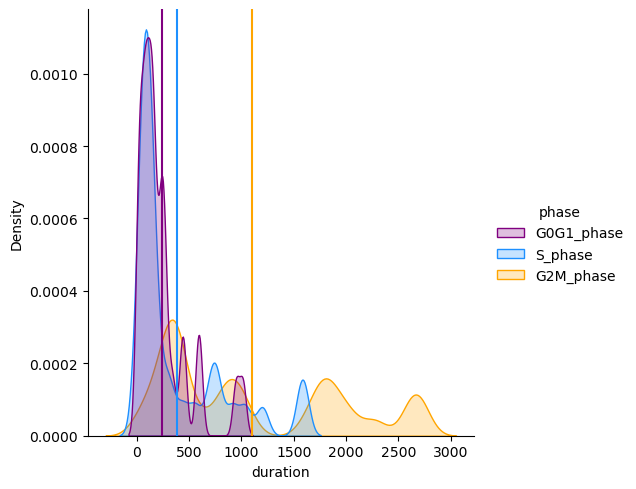

In [28]:
palette = ['purple', 'dodgerblue', 'orange']
print("AVERAGE DURATION OF EACH CELL CYCLE PHASE")
sb.displot(filtered_data, x="duration", kind="kde", hue='phase', fill=True, bw_adjust=.25, palette=palette)
plt.axvline(x=filtered_data[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
            color='orange')
plt.axvline(x=filtered_data[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
            color='purple')
plt.axvline(x=filtered_data[(filtered_data.phase == "S_phase")]["duration"].mean(),
            color='dodgerblue')

#change color into red blue yellow

AVERAGE DURATION OF EACH CELL CYCLE PHASE


/tmp/ipykernel_154260/543291753.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
/tmp/ipykernel_154260/543291753.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
/tmp/ipykernel_154260/543291753.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(x=filtered_data_duration[(filtered_data.phase == "S_phase")]["duration"].mean(),


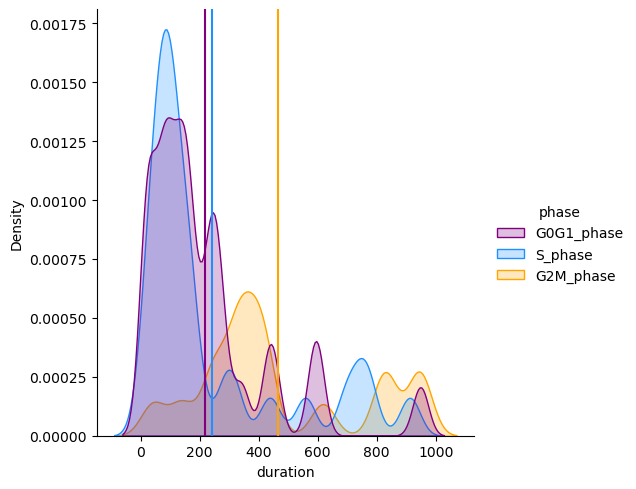

In [30]:
filtered_data_duration = filtered_data[filtered_data['duration'].abs() < 1000]

palette = ['purple', 'dodgerblue', 'orange']
print("AVERAGE DURATION OF EACH CELL CYCLE PHASE")
sb.displot(filtered_data_duration, x="duration", kind="kde", hue='phase', fill=True, bw_adjust=.25, palette=palette)
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
            color='orange')
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
            color='purple')
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "S_phase")]["duration"].mean(),
            color='dodgerblue')

#change color into red blue yellow

EVOLUTION OF THE CELL CYCLE DURING THE SIMULATION


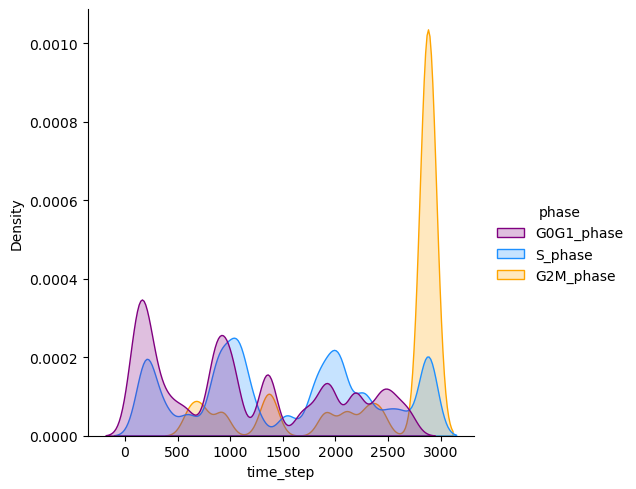

In [31]:
print("EVOLUTION OF THE CELL CYCLE DURING THE SIMULATION")
sb.displot(filtered_data, x="time_step", kind="kde", hue='phase', fill=True, bw_adjust=.20, palette=palette)

Average duration G0G1 phase:  242.51612903225808  minutes
Average duration S phase:  384.19354838709677  minutes
Average duration G2M phase:  1101.111111111111  minutes


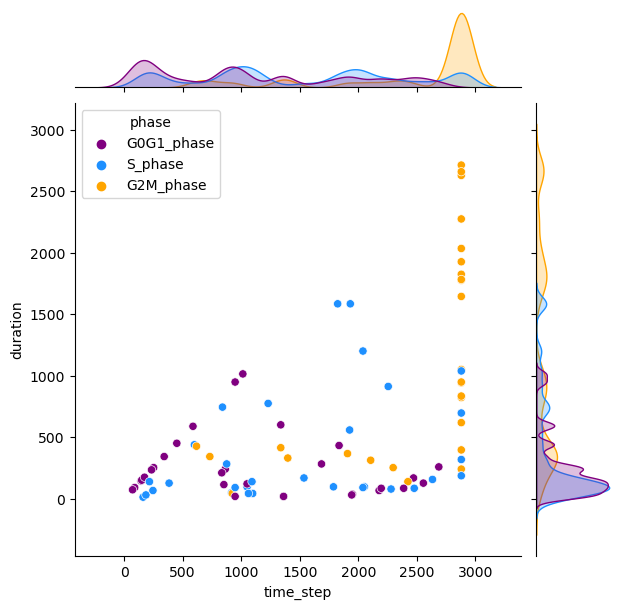

In [32]:
g = sb.JointGrid()
y, x, hue = filtered_data["duration"], filtered_data["time_step"], filtered_data["phase"]
sb.scatterplot(x=x, y=y, hue=hue,  ax=g.ax_joint, palette=palette)
sb.kdeplot(x=x, hue=hue, fill=True, bw_adjust=.25, ax=g.ax_marg_x, legend=False, palette=palette)
sb.kdeplot(y=y, hue=hue, fill=True, bw_adjust=.25, ax=g.ax_marg_y, legend=False, palette=palette)

print("Average duration G0G1 phase: ", filtered_data[(filtered_data.phase == "G0G1_phase")]["duration"].mean(), " minutes")
print("Average duration S phase: ", filtered_data[(filtered_data.phase == "S_phase")]["duration"].mean(), " minutes")
print("Average duration G2M phase: ", filtered_data[(filtered_data.phase == "G2M_phase")]["duration"].mean(), " minutes")

Average duration G0G1 phase:  242.51612903225808  minutes
Average duration S phase:  384.19354838709677  minutes
Average duration G2M phase:  1101.111111111111  minutes


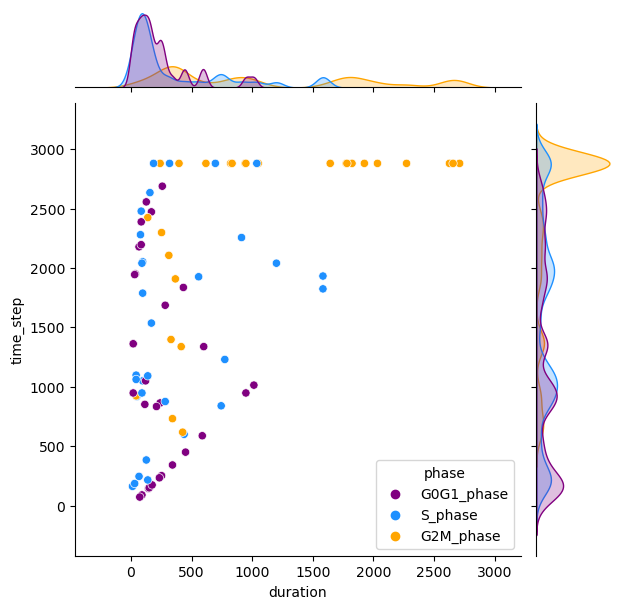

In [33]:
g = sb.JointGrid()
x, y, hue = filtered_data["duration"], filtered_data["time_step"], filtered_data["phase"]
sb.scatterplot(x=x, y=y, hue=hue,  ax=g.ax_joint, palette=palette)
sb.kdeplot(x=x, hue=hue, fill=True, bw_adjust=.25, ax=g.ax_marg_x, legend=False, palette=palette)
sb.kdeplot(y=y, hue=hue, fill=True, bw_adjust=.25, ax=g.ax_marg_y, legend=False, palette=palette)

print("Average duration G0G1 phase: ", filtered_data[(filtered_data.phase == "G0G1_phase")]["duration"].mean(), " minutes")
print("Average duration S phase: ", filtered_data[(filtered_data.phase == "S_phase")]["duration"].mean(), " minutes")
print("Average duration G2M phase: ", filtered_data[(filtered_data.phase == "G2M_phase")]["duration"].mean(), " minutes")

Average duration for each cell cycle phase, detail


<AxesSubplot:xlabel='phase', ylabel='duration'>

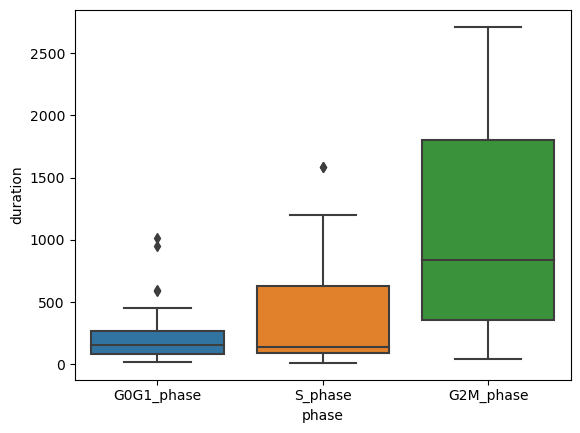

In [34]:
print("Average duration for each cell cycle phase, detail")
sb.boxplot(data=filtered_data, x='phase', y="duration")

<AxesSubplot:xlabel='time_step', ylabel='phase'>

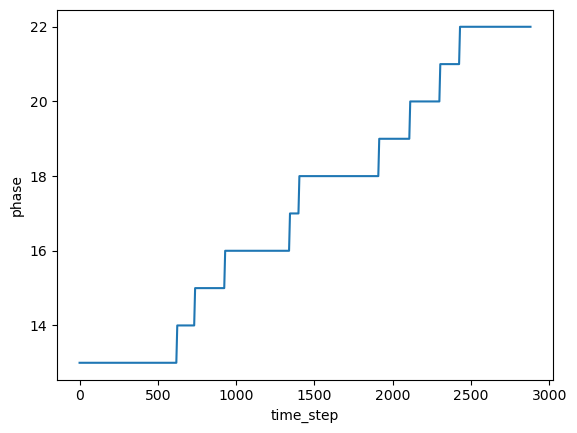

In [35]:
df1 = full_data.groupby('time_step').agg({'phase':'count'})

sb.lineplot(data=df1, x="time_step", y="phase")

<AxesSubplot:xlabel='time_step', ylabel='counts'>

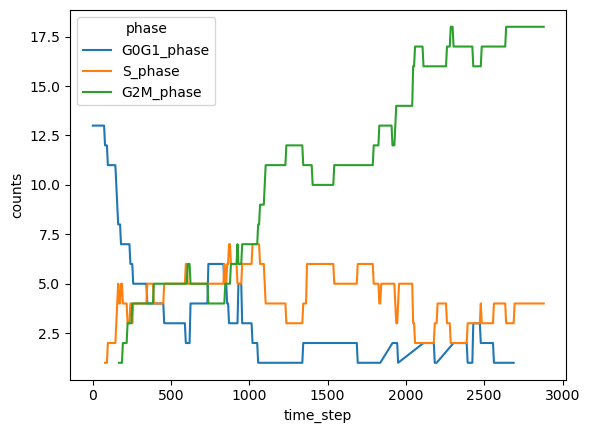

In [36]:
df2 = full_data.groupby(['time_step','phase'])['phase'].count().reset_index(name='counts')

sb.lineplot(data=df2, x="time_step", y="counts", hue="phase")

# FOXO3 KNOCK-OUT ANALYSIS

In [37]:
path = home + "/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout"

xml_files = []


for folder, cose, files in os.walk(path):
    for name in files:
        if name.endswith(".xml") & name.startswith("output"):
            xml_files.append(name)
            
xml_files.sort()
xml_files

['output00000000.xml',
 'output00000001.xml',
 'output00000002.xml',
 'output00000003.xml',
 'output00000004.xml',
 'output00000005.xml',
 'output00000006.xml',
 'output00000007.xml',
 'output00000008.xml',
 'output00000009.xml',
 'output00000010.xml',
 'output00000011.xml',
 'output00000012.xml',
 'output00000013.xml',
 'output00000014.xml',
 'output00000015.xml',
 'output00000016.xml',
 'output00000017.xml',
 'output00000018.xml',
 'output00000019.xml',
 'output00000020.xml',
 'output00000021.xml',
 'output00000022.xml',
 'output00000023.xml',
 'output00000024.xml',
 'output00000025.xml',
 'output00000026.xml',
 'output00000027.xml',
 'output00000028.xml',
 'output00000029.xml',
 'output00000030.xml',
 'output00000031.xml',
 'output00000032.xml',
 'output00000033.xml',
 'output00000034.xml',
 'output00000035.xml',
 'output00000036.xml',
 'output00000037.xml',
 'output00000038.xml',
 'output00000039.xml',
 'output00000040.xml',
 'output00000041.xml',
 'output00000042.xml',
 'output000

In [38]:
full_data = pd.DataFrame(columns=["time_step", "ID", "phase", "duration"])    

for file in xml_files:
    
    mcds = pc.pyMCDS(file, path)
    
    time = mcds.data["metadata"]["current_time"]
    
    for i in mcds.data["discrete_cells"]["ID"]:
        ID = i
        index = np.where(mcds.data["discrete_cells"]["ID"] == ID)
        phase = phase_dict[int(mcds.data["discrete_cells"]["current_phase"][index])]
        phase_duration = int(mcds.data["discrete_cells"]["elapsed_time_in_phase"][index][0])
        new_entry = pd.Series({"time_step":time, "ID":ID,
                     "phase":phase, "duration":phase_duration})
        full_data = pd.concat([full_data, new_entry.to_frame().T], ignore_index=True)

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000000.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000000_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000000_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000001.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000001_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000001_cells.mat
Readin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000018_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000019.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000019_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000019_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000020.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000020_microenvironment0.mat
Parsing oxygen data
workin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000037_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000038.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000038_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000038_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000039.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000039_microenvironment0.mat
Parsing oxygen data
workin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000058_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000059.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000059_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000059_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000060.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000060_microenvironment0.mat
Parsing oxygen data
workin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000080_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000081.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000081_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000081_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000082.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000082_microenvironment0.mat
Parsing oxygen data
workin

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000101_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000101_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000102.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000102_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000102_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000103.xml
Readin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000121_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000122.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000122_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000122_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000123.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000123_microenvironment0.mat
Parsing oxygen data
workin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000142_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000143.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000143_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000143_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000144.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000144_microenvironment0.mat
Parsing oxygen data
workin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000163_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000164.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000164_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000164_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000165.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000165_microenvironment0.mat
Parsing oxygen data
workin

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000182_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000182_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000183.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000183_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000183_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000184.xml
Readin

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000202_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000202_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000203.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000203_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000203_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000204.xml
Readin

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000222_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000222_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000223.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000223_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000223_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000224.xml
Readin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000240_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000241.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000241_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000241_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000242.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000242_microenvironment0.mat
Parsing oxygen data
workin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000258_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000259.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000259_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000259_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000260.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000260_microenvironment0.mat
Parsing oxygen data
workin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000276_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000277.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000277_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000277_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000278.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000278_microenvironment0.mat
Parsing oxygen data
workin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000295_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000296.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000296_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000296_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000297.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000297_microenvironment0.mat
Parsing oxygen data
workin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000313_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000314.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000314_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000314_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000315.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000315_microenvironment0.mat
Parsing oxygen data
workin

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000333_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000334.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000334_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000334_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000335.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000335_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Readin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000350_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000351.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000351_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000351_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000352.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000352_microenvironment0.mat
Parsing oxygen data
workin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000367_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000368.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000368_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000368_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000369.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000369_microenvironment0.mat
Parsing oxygen data
workin

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000385_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000385_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000386.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000386_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000386_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000387.xml
Readin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000403_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000404.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000404_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000404_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000405.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000405_microenvironment0.mat
Parsing oxygen data
workin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000420_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000421.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000421_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000421_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000422.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000422_microenvironment0.mat
Parsing oxygen data
workin

Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000437_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000438.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000438_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000438_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000439.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000439_microenvironment0.mat
Parsin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000456_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000457.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000457_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000457_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000458.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000458_microenvironment0.mat
Parsing oxygen data
workin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000476_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000477.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000477_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000477_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000478.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_foxo3_knockout/output00000478_microenvironment0.mat
Parsing oxygen data
workin

In [39]:
IDs = full_data.ID.drop_duplicates()
phases = ["G0G1_phase", "S_phase", "G2M_phase"]

filtered_data = pd.DataFrame(columns=["time_step", "ID", "phase", "duration"])

for name in IDs:
    for phase in phases:
        a = filter_duration(full_data, phase, name)
        filtered_data = pd.concat([filtered_data, a], ignore_index=True)

AVERAGE DURATION OF EACH CELL CYCLE PHASE


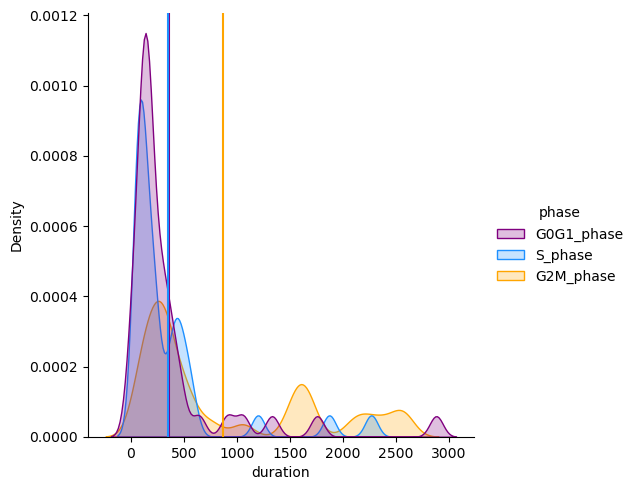

In [40]:
palette = ['purple', 'dodgerblue', 'orange']
print("AVERAGE DURATION OF EACH CELL CYCLE PHASE")
sb.displot(filtered_data, x="duration", kind="kde", hue='phase', fill=True, bw_adjust=.25, palette=palette)
plt.axvline(x=filtered_data[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
            color='orange')
plt.axvline(x=filtered_data[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
            color='purple')
plt.axvline(x=filtered_data[(filtered_data.phase == "S_phase")]["duration"].mean(),
            color='dodgerblue')

#change color into red blue yellow

AVERAGE DURATION OF EACH CELL CYCLE PHASE


/tmp/ipykernel_154260/3774474368.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
/tmp/ipykernel_154260/3774474368.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
/tmp/ipykernel_154260/3774474368.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(x=filtered_data_duration[(filtered_data.phase == "S_phase")]["duration"].mean(),


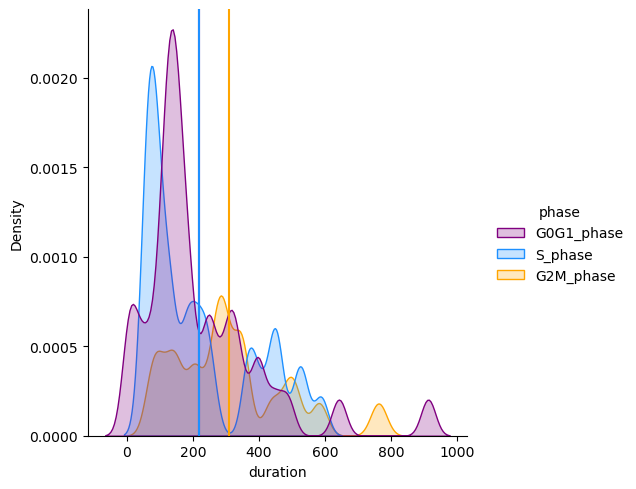

In [41]:
filtered_data_duration = filtered_data[filtered_data['duration'].abs() < 1000]

palette = ['purple', 'dodgerblue', 'orange']
print("AVERAGE DURATION OF EACH CELL CYCLE PHASE")
sb.displot(filtered_data_duration, x="duration", kind="kde", hue='phase', fill=True, bw_adjust=.25, palette=palette)
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
            color='orange')
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
            color='purple')
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "S_phase")]["duration"].mean(),
            color='dodgerblue')

#change color into red blue yellow

EVOLUTION OF THE CELL CYCLE DURING THE SIMULATION


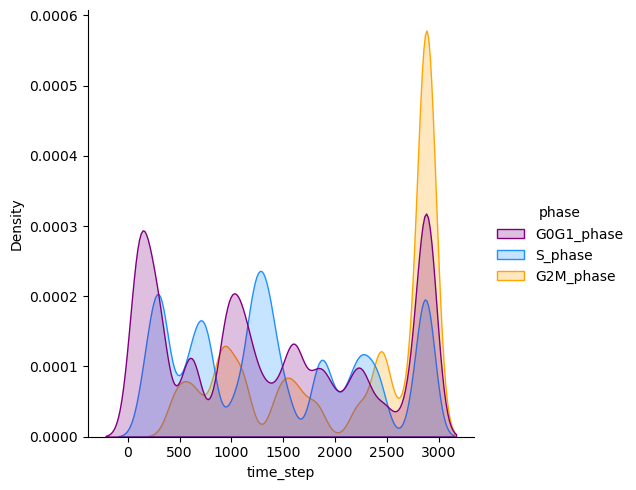

In [42]:
print("EVOLUTION OF THE CELL CYCLE DURING THE SIMULATION")
sb.displot(filtered_data, x="time_step", kind="kde", hue='phase', fill=True, bw_adjust=.20, palette=palette)

Average duration G0G1 phase:  360.9767441860465  minutes
Average duration S phase:  352.8  minutes
Average duration G2M phase:  873.8709677419355  minutes


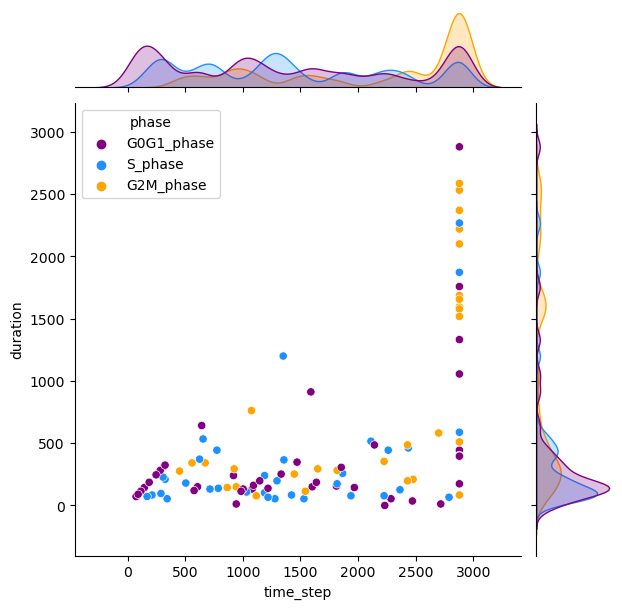

In [43]:
g = sb.JointGrid()
y, x, hue = filtered_data["duration"], filtered_data["time_step"], filtered_data["phase"]
sb.scatterplot(x=x, y=y, hue=hue,  ax=g.ax_joint, palette=palette)
sb.kdeplot(x=x, hue=hue, fill=True, bw_adjust=.25, ax=g.ax_marg_x, legend=False, palette=palette)
sb.kdeplot(y=y, hue=hue, fill=True, bw_adjust=.25, ax=g.ax_marg_y, legend=False, palette=palette)

print("Average duration G0G1 phase: ", filtered_data[(filtered_data.phase == "G0G1_phase")]["duration"].mean(), " minutes")
print("Average duration S phase: ", filtered_data[(filtered_data.phase == "S_phase")]["duration"].mean(), " minutes")
print("Average duration G2M phase: ", filtered_data[(filtered_data.phase == "G2M_phase")]["duration"].mean(), " minutes")

Average duration G0G1 phase:  360.9767441860465  minutes
Average duration S phase:  352.8  minutes
Average duration G2M phase:  873.8709677419355  minutes


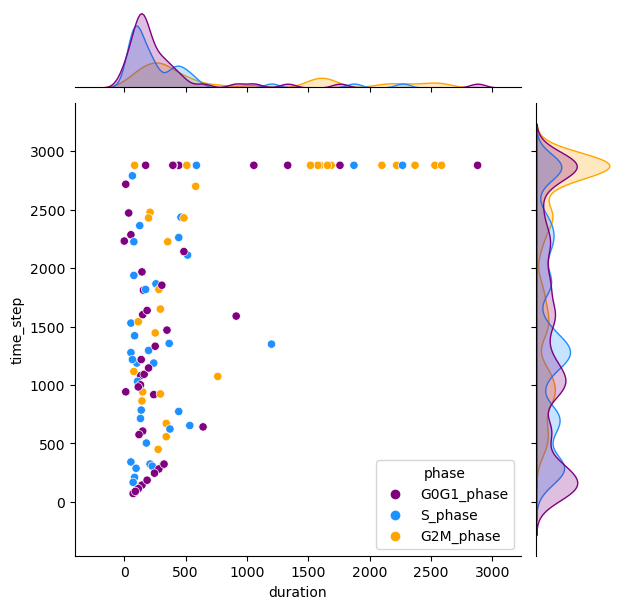

In [44]:
g = sb.JointGrid()
x, y, hue = filtered_data["duration"], filtered_data["time_step"], filtered_data["phase"]
sb.scatterplot(x=x, y=y, hue=hue,  ax=g.ax_joint, palette=palette)
sb.kdeplot(x=x, hue=hue, fill=True, bw_adjust=.25, ax=g.ax_marg_x, legend=False, palette=palette)
sb.kdeplot(y=y, hue=hue, fill=True, bw_adjust=.25, ax=g.ax_marg_y, legend=False, palette=palette)

print("Average duration G0G1 phase: ", filtered_data[(filtered_data.phase == "G0G1_phase")]["duration"].mean(), " minutes")
print("Average duration S phase: ", filtered_data[(filtered_data.phase == "S_phase")]["duration"].mean(), " minutes")
print("Average duration G2M phase: ", filtered_data[(filtered_data.phase == "G2M_phase")]["duration"].mean(), " minutes")

Average duration for each cell cycle phase, detail


<AxesSubplot:xlabel='phase', ylabel='duration'>

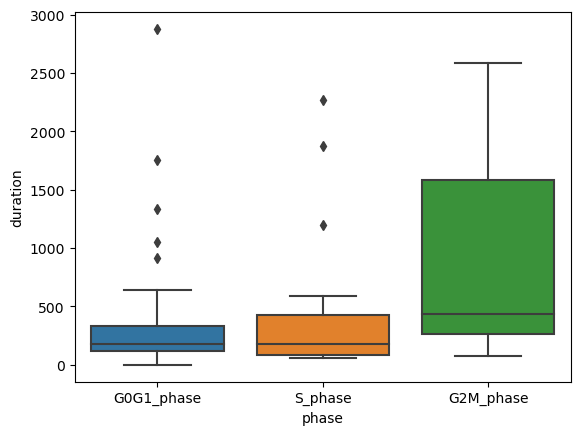

In [45]:
print("Average duration for each cell cycle phase, detail")
sb.boxplot(data=filtered_data, x='phase', y="duration")

<AxesSubplot:xlabel='time_step', ylabel='phase'>

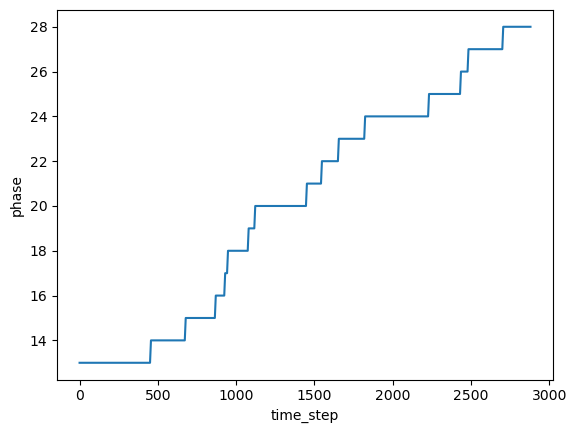

In [46]:
df1 = full_data.groupby('time_step').agg({'phase':'count'})

sb.lineplot(data=df1, x="time_step", y="phase")

<AxesSubplot:xlabel='time_step', ylabel='counts'>

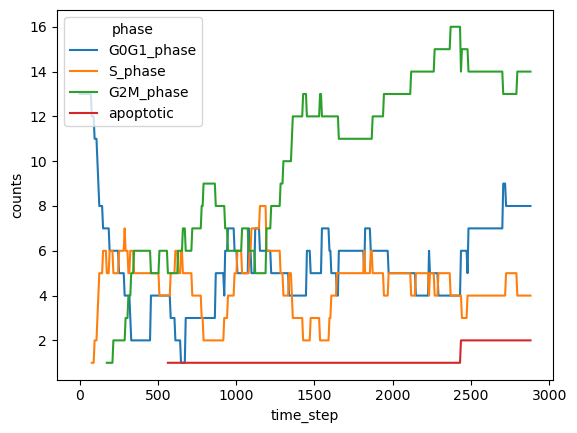

In [47]:
df2 = full_data.groupby(['time_step','phase'])['phase'].count().reset_index(name='counts')

sb.lineplot(data=df2, x="time_step", y="counts", hue="phase")

# p110_H and PI3K_H KNOCK-IN ANALYSIS

In [48]:
path = home + "/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants"

xml_files = []


for folder, cose, files in os.walk(path):
    for name in files:
        if name.endswith(".xml") & name.startswith("output"):
            xml_files.append(name)
            
xml_files.sort()
xml_files

['output00000000.xml',
 'output00000001.xml',
 'output00000002.xml',
 'output00000003.xml',
 'output00000004.xml',
 'output00000005.xml',
 'output00000006.xml',
 'output00000007.xml',
 'output00000008.xml',
 'output00000009.xml',
 'output00000010.xml',
 'output00000011.xml',
 'output00000012.xml',
 'output00000013.xml',
 'output00000014.xml',
 'output00000015.xml',
 'output00000016.xml',
 'output00000017.xml',
 'output00000018.xml',
 'output00000019.xml',
 'output00000020.xml',
 'output00000021.xml',
 'output00000022.xml',
 'output00000023.xml',
 'output00000024.xml',
 'output00000025.xml',
 'output00000026.xml',
 'output00000027.xml',
 'output00000028.xml',
 'output00000029.xml',
 'output00000030.xml',
 'output00000031.xml',
 'output00000032.xml',
 'output00000033.xml',
 'output00000034.xml',
 'output00000035.xml',
 'output00000036.xml',
 'output00000037.xml',
 'output00000038.xml',
 'output00000039.xml',
 'output00000040.xml',
 'output00000041.xml',
 'output00000042.xml',
 'output000

In [49]:
full_data = pd.DataFrame(columns=["time_step", "ID", "phase", "duration"])    

for file in xml_files:
    
    mcds = pc.pyMCDS(file, path)
    
    time = mcds.data["metadata"]["current_time"]
    
    for i in mcds.data["discrete_cells"]["ID"]:
        ID = i
        index = np.where(mcds.data["discrete_cells"]["ID"] == ID)
        phase = phase_dict[int(mcds.data["discrete_cells"]["current_phase"][index])]
        phase_duration = int(mcds.data["discrete_cells"]["elapsed_time_in_phase"][index][0])
        new_entry = pd.Series({"time_step":time, "ID":ID,
                     "phase":phase, "duration":phase_duration})
        full_data = pd.concat([full_data, new_entry.to_frame().T], ignore_index=True)

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000000.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000000_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000000_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000001.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000001_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000001_cells.mat
Readin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000018_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000019.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000019_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000019_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000020.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000020_microenvironment0.mat
Parsing oxygen data
workin

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000038_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000038_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000039.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000039_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000039_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000040.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Readin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000058_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000059.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000059_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000059_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000060.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000060_microenvironment0.mat
Parsing oxygen data
workin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000077_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000078.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000078_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000078_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000079.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000079_microenvironment0.mat
Parsing oxygen data
workin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000097_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000098.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000098_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000098_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000099.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000099_microenvironment0.mat
Parsing oxygen data
workin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000117_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000118.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000118_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000118_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000119.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000119_microenvironment0.mat
Parsing oxygen data
workin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000137_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000138.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000138_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000138_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000139.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000139_microenvironment0.mat
Parsing oxygen data
workin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000156_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000157.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000157_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000157_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000158.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000158_microenvironment0.mat
Parsing oxygen data
workin

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000177.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000177_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000177_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000178.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000178_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000178_cells.mat
Readin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000195_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000196.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000196_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000196_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000197.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000197_microenvironment0.mat
Parsing oxygen data
workin

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000213_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000213_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000214.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000214_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000214_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000215.xml
Readin

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000233.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000233_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000233_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000234.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000234_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000234_cells.mat
Readin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000252_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000253.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000253_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000253_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000254.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000254_microenvironment0.mat
Parsing oxygen data
workin

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000270.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000270_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000270_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000271.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000271_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000271_cells.mat
Readin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000288_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000289.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000289_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000289_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000290.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000290_microenvironment0.mat
Parsing oxygen data
workin

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000308.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000308_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000308_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000309.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000309_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000309_cells.mat
Readin

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000325.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000325_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000325_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000326.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000326_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000326_cells.mat
Readin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000342_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000343.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000343_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000343_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000344.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000344_microenvironment0.mat
Parsing oxygen data
workin

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000362.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000362_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000362_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000363.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000363_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000363_cells.mat
Readin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000379_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000380.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000380_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000380_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000381.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000381_microenvironment0.mat
Parsing oxygen data
workin

working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000398_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000399.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000399_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000399_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000400.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000400_microenvironment0.mat
Parsing oxygen data
workin

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000416.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000416_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000416_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000417.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000417_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000417_cells.mat
Readin

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000433.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000433_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000433_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000434.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000434_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000434_cells.mat
Readin

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000451.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000451_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000451_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000452.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000452_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000452_cells.mat
Readin

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000469.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000469_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000469_cells.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000470.xml
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/initial_mesh0.mat
Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000470_microenvironment0.mat
Parsing oxygen data
working on discrete cell data...

Reading /home/marco/Documents/PhD/github/private_repo/PhysiBoSS/output_double_mutants/output00000470_cells.mat
Readin

In [50]:
IDs = full_data.ID.drop_duplicates()
phases = ["G0G1_phase", "S_phase", "G2M_phase"]

filtered_data = pd.DataFrame(columns=["time_step", "ID", "phase", "duration"])

for name in IDs:
    for phase in phases:
        a = filter_duration(full_data, phase, name)
        filtered_data = pd.concat([filtered_data, a], ignore_index=True)

AVERAGE DURATION OF EACH CELL CYCLE PHASE


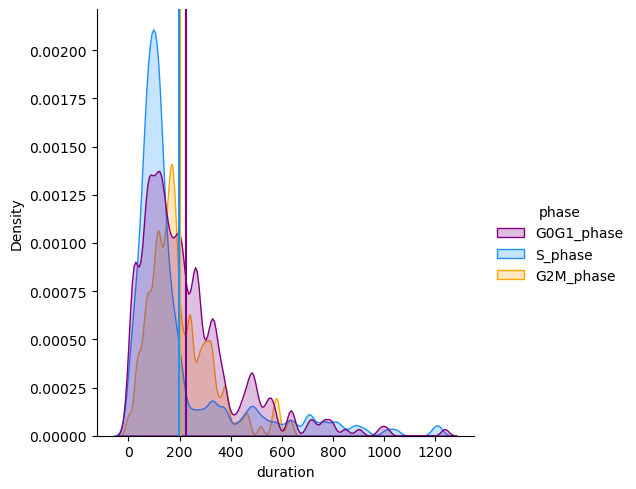

In [51]:
palette = ['purple', 'dodgerblue', 'orange']
print("AVERAGE DURATION OF EACH CELL CYCLE PHASE")
sb.displot(filtered_data, x="duration", kind="kde", hue='phase', fill=True, bw_adjust=.25, palette=palette)
plt.axvline(x=filtered_data[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
            color='orange')
plt.axvline(x=filtered_data[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
            color='purple')
plt.axvline(x=filtered_data[(filtered_data.phase == "S_phase")]["duration"].mean(),
            color='dodgerblue')

#change color into red blue yellow

AVERAGE DURATION OF EACH CELL CYCLE PHASE


/tmp/ipykernel_154260/3774474368.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
/tmp/ipykernel_154260/3774474368.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
/tmp/ipykernel_154260/3774474368.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(x=filtered_data_duration[(filtered_data.phase == "S_phase")]["duration"].mean(),


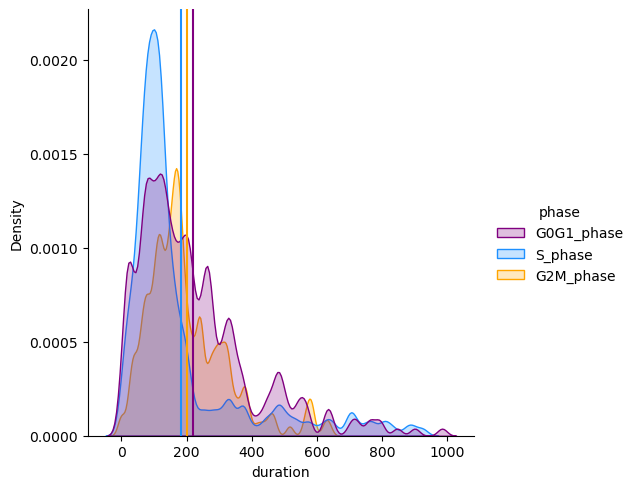

In [52]:
filtered_data_duration = filtered_data[filtered_data['duration'].abs() < 1000]

palette = ['purple', 'dodgerblue', 'orange']
print("AVERAGE DURATION OF EACH CELL CYCLE PHASE")
sb.displot(filtered_data_duration, x="duration", kind="kde", hue='phase', fill=True, bw_adjust=.25, palette=palette)
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
            color='orange')
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
            color='purple')
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "S_phase")]["duration"].mean(),
            color='dodgerblue')

#change color into red blue yellow

EVOLUTION OF THE CELL CYCLE DURING THE SIMULATION


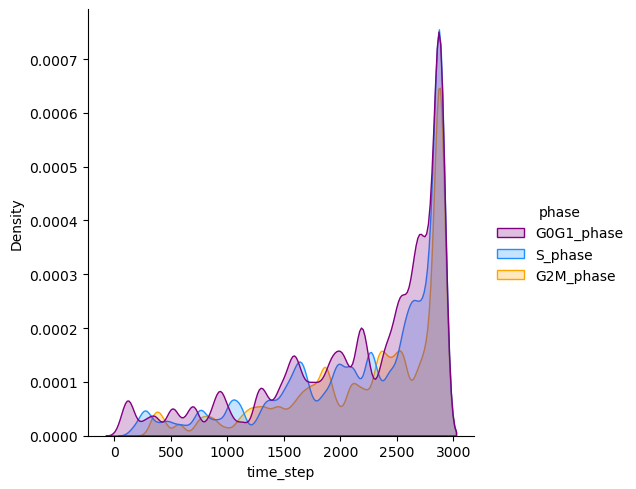

In [53]:
print("EVOLUTION OF THE CELL CYCLE DURING THE SIMULATION")
sb.displot(filtered_data, x="time_step", kind="kde", hue='phase', fill=True, bw_adjust=.20, palette=palette)

Average duration G0G1 phase:  226.45544554455446  minutes
Average duration S phase:  199.464  minutes
Average duration G2M phase:  200.06153846153848  minutes


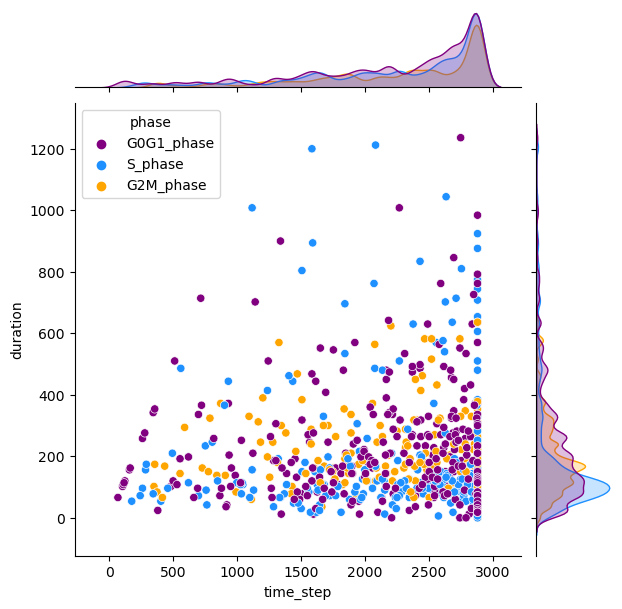

In [54]:
g = sb.JointGrid()
y, x, hue = filtered_data["duration"], filtered_data["time_step"], filtered_data["phase"]
sb.scatterplot(x=x, y=y, hue=hue,  ax=g.ax_joint, palette=palette)
sb.kdeplot(x=x, hue=hue, fill=True, bw_adjust=.25, ax=g.ax_marg_x, legend=False, palette=palette)
sb.kdeplot(y=y, hue=hue, fill=True, bw_adjust=.25, ax=g.ax_marg_y, legend=False, palette=palette)

print("Average duration G0G1 phase: ", filtered_data[(filtered_data.phase == "G0G1_phase")]["duration"].mean(), " minutes")
print("Average duration S phase: ", filtered_data[(filtered_data.phase == "S_phase")]["duration"].mean(), " minutes")
print("Average duration G2M phase: ", filtered_data[(filtered_data.phase == "G2M_phase")]["duration"].mean(), " minutes")

Average duration G0G1 phase:  226.45544554455446  minutes
Average duration S phase:  199.464  minutes
Average duration G2M phase:  200.06153846153848  minutes


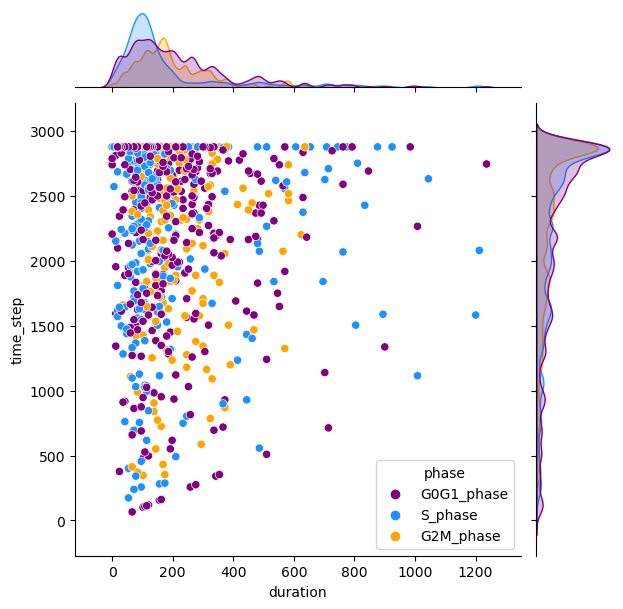

In [55]:
g = sb.JointGrid()
x, y, hue = filtered_data["duration"], filtered_data["time_step"], filtered_data["phase"]
sb.scatterplot(x=x, y=y, hue=hue,  ax=g.ax_joint, palette=palette)
sb.kdeplot(x=x, hue=hue, fill=True, bw_adjust=.25, ax=g.ax_marg_x, legend=False, palette=palette)
sb.kdeplot(y=y, hue=hue, fill=True, bw_adjust=.25, ax=g.ax_marg_y, legend=False, palette=palette)

print("Average duration G0G1 phase: ", filtered_data[(filtered_data.phase == "G0G1_phase")]["duration"].mean(), " minutes")
print("Average duration S phase: ", filtered_data[(filtered_data.phase == "S_phase")]["duration"].mean(), " minutes")
print("Average duration G2M phase: ", filtered_data[(filtered_data.phase == "G2M_phase")]["duration"].mean(), " minutes")

Average duration for each cell cycle phase, detail


<AxesSubplot:xlabel='phase', ylabel='duration'>

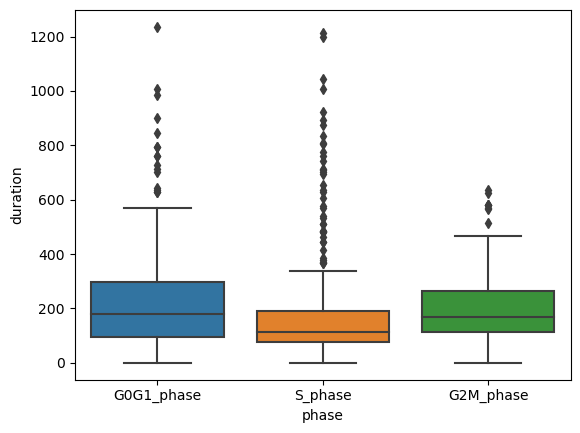

In [56]:
print("Average duration for each cell cycle phase, detail")
sb.boxplot(data=filtered_data, x='phase', y="duration")

<AxesSubplot:xlabel='time_step', ylabel='phase'>

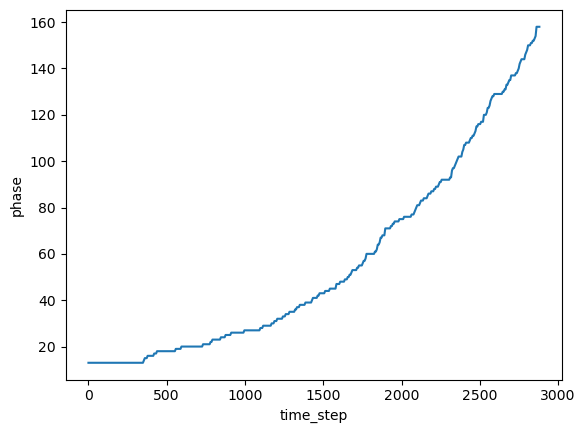

In [57]:
df1 = full_data.groupby('time_step').agg({'phase':'count'})

sb.lineplot(data=df1, x="time_step", y="phase")

<AxesSubplot:xlabel='time_step', ylabel='counts'>

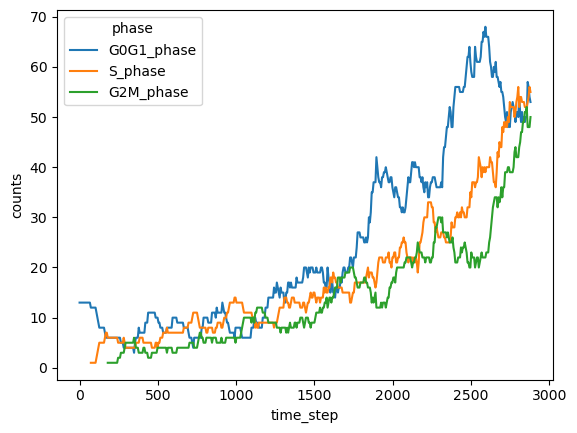

In [58]:
df2 = full_data.groupby(['time_step','phase'])['phase'].count().reset_index(name='counts')

sb.lineplot(data=df2, x="time_step", y="counts", hue="phase")